In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import dask.dataframe as dd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import log_loss
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
import tqdm
from tqdm import tqdm
import warnings
warnings. filterwarnings("ignore") 
from scipy import signal
from biosppy.signals import ecg 
from biosppy.signals import eeg
from biosppy.signals import resp
from scipy.interpolate import interp1d 
import phik
import dask.array as ar
import pickle
import joblib
import random

In [2]:
X_train=dd.read_csv("pilot_train_eda_fe")
X_train=X_train.compute()


In [6]:
#train and cv data are done feature engineering and preprocessing

X_train,X_cv,y_train,y_cv=train_test_split(X_train,y_train,test_size=0.25,random_state=1)

## Feature Engineering 

In [6]:
def remove_noise(data,w):
    n=5 #oder of the filter
    
    b, a = signal.butter(n,w,fs=256) #design a butterworth filter with order N and critical frequnecy w. This will return the filter coefficents
    return signal.filtfilt(b, a, data) 
    

In [61]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html
def interpolation_fn(timestamps,biosppy_ts, biosppy_values):

    interpolation = interp1d(biosppy_ts,biosppy_values, kind="linear", fill_value="extrapolate") #Kind can be linear, quadratic or cubic. fill value is NAN if not given
    return interpolation(timestamps) #this is the time stamps where we need to get the interpolated values That is the time stamps in the dataframe



In [60]:
def biosppy(df):
    #heart rate from ecg
    bio=ecg.ecg(df["filtered_ecg"],sampling_rate=256,show=False)
    
    #interpolate test heart rate data
    df["heart_rate"]=dd.from_array(interpolation_fn(df["time"],bio["heart_rate_ts"],bio["heart_rate"]))
    
    #resp rate from r signal
    bio=ecg.ecg(df["filtered_r"],sampling_rate=256,show=False) 
    #interpolate test heart rate data
    df["resp_rate"]=dd.from_array(interpolation_fn(df["time"],bio["resp_rate_ts"],bio["resp_rate"]))
    
    ##eeg frequency bands
   
    bio=eeg.get_power_features(df[eeg_features],sampling_rate=256) 
    
    alpha_low_feature=[i+"_alpha_low" for i in eeg_features]
    for i in range(20):
        df[alpha_low_feature[i]]=interpolation_fn(df["time"],bio["ts"],bio["alpha_low"][:,i])
    

    alpha_high_feature=[i+"_alpha_high" for i in eeg_features]
    for i in range(20):
        df[alpha_high_feature[i]]=interpolation_fn(df["time"],bio["ts"],bio["alpha_high"][:,i])
    
    theta_feature=[i+"_theta" for i in eeg_features]
    for i in range(20):
        df[theta_feature[i]]=interpolation_fn(df["time"],bio["ts"],bio["theta"][:,i])
   
    
    return df

In [7]:
def potential(df):
    
    df["fp1_f7"]=df["eeg_fp1"]-df["eeg_f7"]
    df["f7_t3"]=df["eeg_f7"]-df["eeg_t3"]
    df["t3_t5"]=df["eeg_t3"]-df["eeg_t5"]
    df["t5_o1"]=df["eeg_t5"]-df["eeg_o1"]
    df["p3_o1"]=df["eeg_p3"]-df["eeg_o1"]
    df["c3_p3"]=df["eeg_c3"]-df["eeg_p3"]
    df["f3_c3"]=df["eeg_f3"]-df["eeg_c3"]
    df["fp1_f3"]=df["eeg_fp1"]-df["eeg_f3"]

    df["fzcz"]=df["eeg_fz"]-df["eeg_cz"]
    df["czpz"]=df["eeg_cz"]-df["eeg_pz"]

    df["fp2_f4"]=df["eeg_fp2"]-df["eeg_f4"]
    df["f4_c4"]=df["eeg_f4"]-df["eeg_c4"]
    df["c4_p4"]=df["eeg_c4"]-df["eeg_p4"]
    df["p4_o2"]=df["eeg_p4"]-df["eeg_o2"]
    df["t6_o2"]=df["eeg_t6"]-df["eeg_o2"]
    df["t4_t6"]=df["eeg_t4"]-df["eeg_t6"]
    df["f8_t4"]=df["eeg_f8"]-df["eeg_t4"]
    df["fp2_f8"]=df["eeg_fp2"]-df["eeg_f8"]
    
    return df

## Standardisation of features

In [4]:
eeg_features=['eeg_fp1', 'eeg_f7', 'eeg_f8','eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3','eeg_pz', 'eeg_f3',
              'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz','eeg_c3', 'eeg_cz', 'eeg_o2']


pd=["fp1_f7","f7_t3","t3_t5","t5_o1","p3_o1","c3_p3","f3_c3","fp1_f3","fzcz","czpz","fp2_f4","f4_c4","c4_p4","p4_o2","t6_o2","t4_t6","f8_t4","fp2_f8"]
alpha_low_features=["alpha_low"+i for i in eeg_features]
alpha_high_features=["alpha_low"+i for i in eeg_features]
theta_features=["alpha_low"+i for i in eeg_features]

features=["filtered_ecg","filtered_r","gsr","resp_rate","heart_rate"]
features.extend(eeg_features)
features.extend(pd)
features.extend(alpha_low_features)
features.extend(alpha_high_features)
features.extend(theta_features)
print(len(features))

103


In [13]:
std=np.load("std.npy")

In [10]:
def standardisation(X_test):
    
    for i in range(len(features)):
        std_1= std[i]
        X_test[features[i]]=std_1.transform(X_test[features[i]].values.reshape(-1,1))
    
     return X_test

In [15]:
y_train=X_train["e"]
y_cv=X_cv["e"]
X_train=X_train.drop(["e","Unnamed: 0"],axis=1)
X_cv=X_cv.drop(["e","Unnamed: 0"],axis=1)

In [7]:
print(X_train.shape)
print(X_cv.shape)

(3650565, 105)
(1216856, 105)


## Loading the model


In [16]:
#Loading the trained model
model=joblib.load('model1.pkl')

## Predictions for a random cv data

In [46]:
a=random.sample(range(0,X_cv.shape[0]),1)
print(a)

[245637]


In [47]:
pred=model.predict_proba(X_cv.iloc[a])
final_pred=np.argmax(pred,axis=1)

In [48]:
print("The actual output is ", y_cv.iloc[a].values)
print("Model predicted output is ",final_pred)

The actual output is  [0]
Model predicted output is  [0]


## Predictions for test data

In [14]:
X_test=dd.read_csv("test.csv")
X_test=X_test.drop(['id','experiment','seat'],axis=1)
X_test=X_test.fillna(0).compute()

In [6]:
def function1(X_test):
    X_test["filtered_ecg"]=dd.from_array(remove_noise(X_test["ecg"],100))
    X_test=X_test.drop("ecg",axis=1)
    
    X_test["filtered_r"]=dd.from_array(remove_noise(X_test["r"],0.7))
    X_test=X_test.drop("r",axis=1)
    
    X_test=biosppy(X_test)
    X_test=potential(X_test)
    X_test=standardisation(X_test)
    
    return X_test

In [11]:
X_test=function1(X_test)

In [37]:
#the test data was splitted into 5 files after all the preprocessing.So data from each file is read and predictions are done
r=[]
for i in tqdm(range(1,6)):
    data=dd.read_csv("out_"+str(i)+".csv")
    data=data.compute()
    
    data=data.drop(data.columns[0],axis=1)
    r.extend(model.predict_proba(data))
    

100%|██████████| 5/5 [08:00<00:00, 96.18s/it] 


In [39]:
r=np.array(r)

In [40]:
sub=pd.DataFrame()
sub["id"]=np.arange(0,17965143)
sub["A"]=r[:,0]
sub["B"]=r[:,1]
sub["C"]=r[:,2]
sub["D"]=r[:,3]

In [41]:
sub

,id,A,B,C,D
0,0,0.971920,0.000578,0.026464,0.001037
1,1,0.971920,0.000578,0.026464,0.001037
2,2,0.971924,0.000578,0.026464,0.001034
3,3,0.971924,0.000578,0.026464,0.001034
4,4,0.971924,0.000578,0.026464,0.001034
...,...,...,...,...,...
17965138,17965138,0.958423,0.000480,0.013821,0.027277
17965139,17965139,0.961352,0.000449,0.012691,0.025508
17965140,17965140,0.958423,0.000480,0.013821,0.027277
17965141,17965141,0.961352,0.000449,0.012691,0.025508


In [44]:
sub.to_csv("submission.csv",index=False)

## Kaggle score obtained (multiclass log loss)

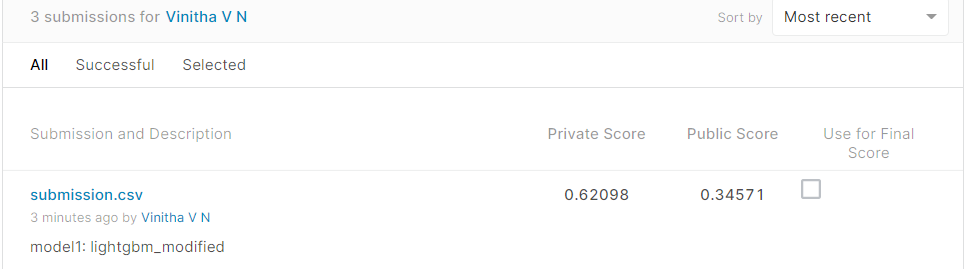